In [1]:
# Стандартный импорт
import torch
import torch.nn as nn
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

## 2. Переобучение

Итак, мы изучили несколько продвинутых алгоритмов оптимизации, которые позволят нам обучать сети намного эффективнее.

Складывается впечатление, что теперь нужно только подготовить данные, выбрать/придумать архитектуру, применить один из изученных эффективных алгоритмов - и готово, задача решена.

Проверим, так ли это на самом деле.

### 2.1 Подготовим данные

In [2]:
# Сгенерируем данные
from impls.data import MakePattern2d, split_data
from impls.plots import decision_plot

n1 = 200
n2 = 200
n3 = 200

n = n1 + n2 + n3

pattern_1 = MakePattern2d(shape='x', n_points=n1, scale=(2.0, 2.0), sgma=(0.4, 0.4), x0=(0.0, 0.0))
pattern_2 = MakePattern2d(shape='o', n_points=n2, scale=(1.5, 1.5), sgma=(0.7, 0.7), x0=(-3.0, 0.0))
pattern_3 = MakePattern2d(shape='b', n_points=n3, sgma=(0.8, 0.8), x0=(-3.0, 0.0))

data_x = np.concat([pattern_1, pattern_2, pattern_3])

labels = [1] *n1 + [2] *n2 + [3] *n3
labels_v = [[1, 0, 0]] *n1 + [[0, 1, 0]] *n2 + [[0, 0, 1]] *n3

idx = np.random.permutation(n)
labels = torch.FloatTensor([labels[i] for i in idx])
data_x = torch.FloatTensor(data_x[idx, :])
data_y = torch.FloatTensor([labels_v[i] for i in idx])

print(labels[:10])
print(data_x.shape)
print(data_y.shape)

tensor([3., 1., 1., 2., 2., 2., 2., 2., 3., 3.])
torch.Size([600, 2])
torch.Size([600, 3])


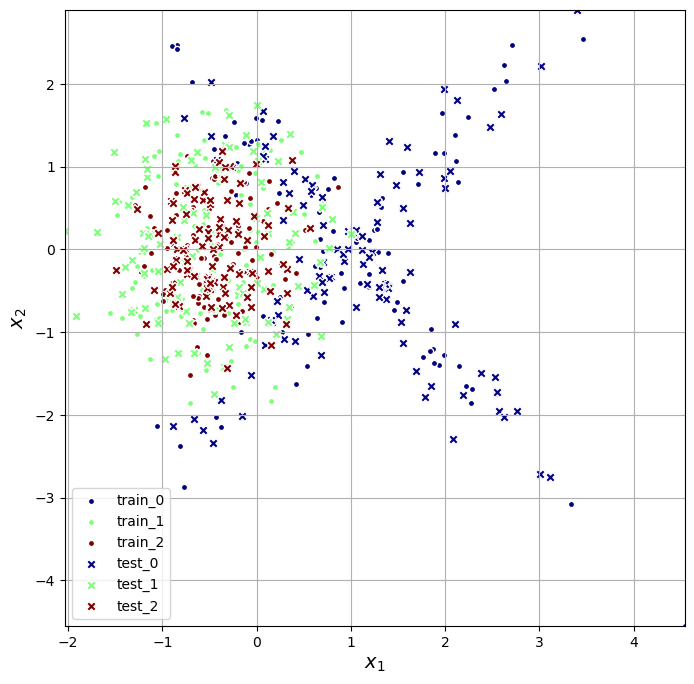

In [3]:
# Разобьём данные на тренировочную и валидационную выборки

X_train, X_test, y_train, y_test = split_data(data_x, data_y, 0.5)

# Отнормируем данные:
from impls.utils import StandardScaler

x_scaler = StandardScaler()
x_scaler.fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

data_dict = {}
data_dict['train'] = {'X': X_train, 'y': y_train, 'm': 'o', 'msize':20}
data_dict['test'] = {'X': X_test, 'y': y_test, 'm': 'X', 'msize':50}

from impls.plots import plot_2d


plot_2d(data=data_dict)

### 2.2. Подготовим модель

In [4]:
class Classifier(nn.Module):
    
    def __init__(self, in_dim=2, hidden_dim=4, n_classes=3):

        super().__init__()
        
        # YOUR CODE
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.ac1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ac2 = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_dim, n_classes)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):

        # YOUR CODE
        x = self.ac1(self.fc1(x))
        x = self.ac2(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(x)
        
        return x

In [5]:
def accuracy_score(y_true, y_pred):
    
    return (y_true == y_pred).sum()/len(y_true)

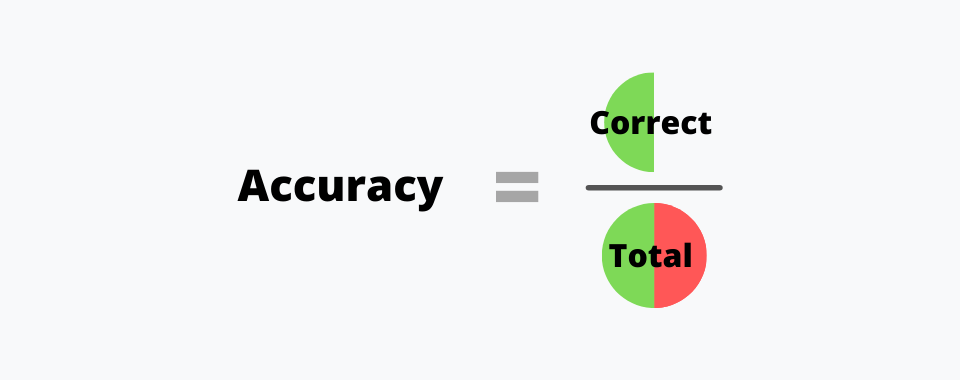

### 2.3 Обучение и оценка моделей

In [13]:
from impls.utils import BatchSampler

# Цикл обучения.
def train_loop(model,\
               optimizer,
               train_samples,
               test_samples,
               loss,
               n_epochs = 30,
               eval_fn = None,
               eval_int = 1):
    '''
    Sample train loop with evaluation governed by arbitrary function.

    eval_fn should accept two arguments:
    - model: nn.Model, which will be evaluated
    - data: dict, which contains 'train' and 'test' sets

    Inputs:
    - model: nn.Model - model, which will be trained
    - optimizer: nn.Optimizer, which will be used during training
    - data: dict(), which contains 
    - loss: loss function

    Optional inputs:
    - n_epochs: number of training epochs (default: 30)
    - eval_fn: evaluation function, which will be used during training (default: same as loss)
    - eval_int: interval in epochs, for which to evaluate model

    Returns:
    - eval_history: dict(), which contains loss history (keys: 'train' and 'test), and indexes of epochs, on which evaluation was performed (key: 'epochs')
    '''

    eval_history = {'train': [], 'test': [], 'epochs': []}

    model.train()

    for epoch in tqdm.trange(n_epochs):

        # Learning step
        for X_batch, y_batch in train_samples:

            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss_train = loss(y_pred, y_batch)
            loss_train.backward()

            optimizer.step()

        # Evaluation step
        # Обратите внимание, что тестирование тоже происходит по батчам - 
        # это в случаях, когда весь набор данных не помещается в RAM.
        
        if (epoch % eval_int) == 0:

            model.eval()

            with torch.no_grad():

                if eval_fn==None:

                    eval_test = 0

                    for X_batch, y_batch in test_samples:

                        y_pred = model(X_batch)
                        eval_test += loss(y_pred, y_batch).item()

                    eval_train = loss_train.item()
                else: 
                    eval_train, eval_test = eval_fn(model, train_samples, test_samples)

            eval_history['epochs'].append(epoch)
            eval_history['train'].append(eval_train)
            eval_history['test'].append(eval_test)

            model.train()

    return eval_history

# 
def fit_and_compare(models_dict,\
                    data_dict,
                    loss, 
                    opts_dict,
                    n_epochs,
                    train_loop,
                    eval_fn=None,
                    sq_size=5,
                    batch_size=10
                    ):
    
    n_models = len(models_dict)
    keys = [*models_dict.keys()]

    X_train = data_dict['train']['X']
    y_train = data_dict['train']['y']
    X_test = data_dict['test']['X']
    y_test = data_dict['test']['y']
    

    train_sampler = BatchSampler(X_train, y_train, batch_size)
    test_sampler = BatchSampler(X_test, y_test, batch_size)

    train_batches = train_sampler.sample()
    test_batches = test_sampler.sample()

    evals = {}
    for key in keys:

        try:
            optimizer = opts_dict[key]['opt']
            opt_params = opts_dict[key]['params']
        except:
            optimizer = opts_dict['default']['opt']
            opt_params = opts_dict['default']['params']

        opt = optimizer(models_dict[key].parameters(), **opt_params)

        print(f'Optimizing model {key}')

        evals[key] = train_loop(models_dict[key],\
                                train_samples = train_batches,
                                test_samples = test_batches,
                                optimizer=opt,
                                loss=loss,
                                n_epochs=n_epochs,
                                eval_fn=eval_fn)
        
    print('All done!')
    
    fig, axs = plt.subplots(n_models, 2, figsize=(2*sq_size, n_models*sq_size))

    for i in range(n_models):

        key = keys[i]
        eval = evals[key]
        model = models_dict[key]
        
        axs[i][0].plot(eval['epochs'], eval['train'], label='Training Loss')
        axs[i][0].plot(eval['epochs'], eval['test'], label='Test Loss')
        axs[i][0].set_title(f'Model: {key}')
        axs[i][0].set_xlabel('Epoch')
        axs[i][0].set_ylabel('Loss')
        axs[i][0].grid('on')


        with torch.no_grad():
            y_pred = model(X_test)

        _, labels_pred = y_pred.max(dim=1)
        _, labels_true = y_test.max(dim=1)

        accuracy = accuracy_score(labels_true, labels_pred)
        
        axs[i][1].set_title(f'Model: {key}; Accuracy: {accuracy:.2f}')
        decision_plot(model, add_data = data_dict, grid_n=(200, 200), ax=axs[i][1])
        
        

    plt.tight_layout()

    plt.show()


Optimizing model small


100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


Optimizing model big


100%|██████████| 200/200 [00:35<00:00,  5.57it/s]


All done!


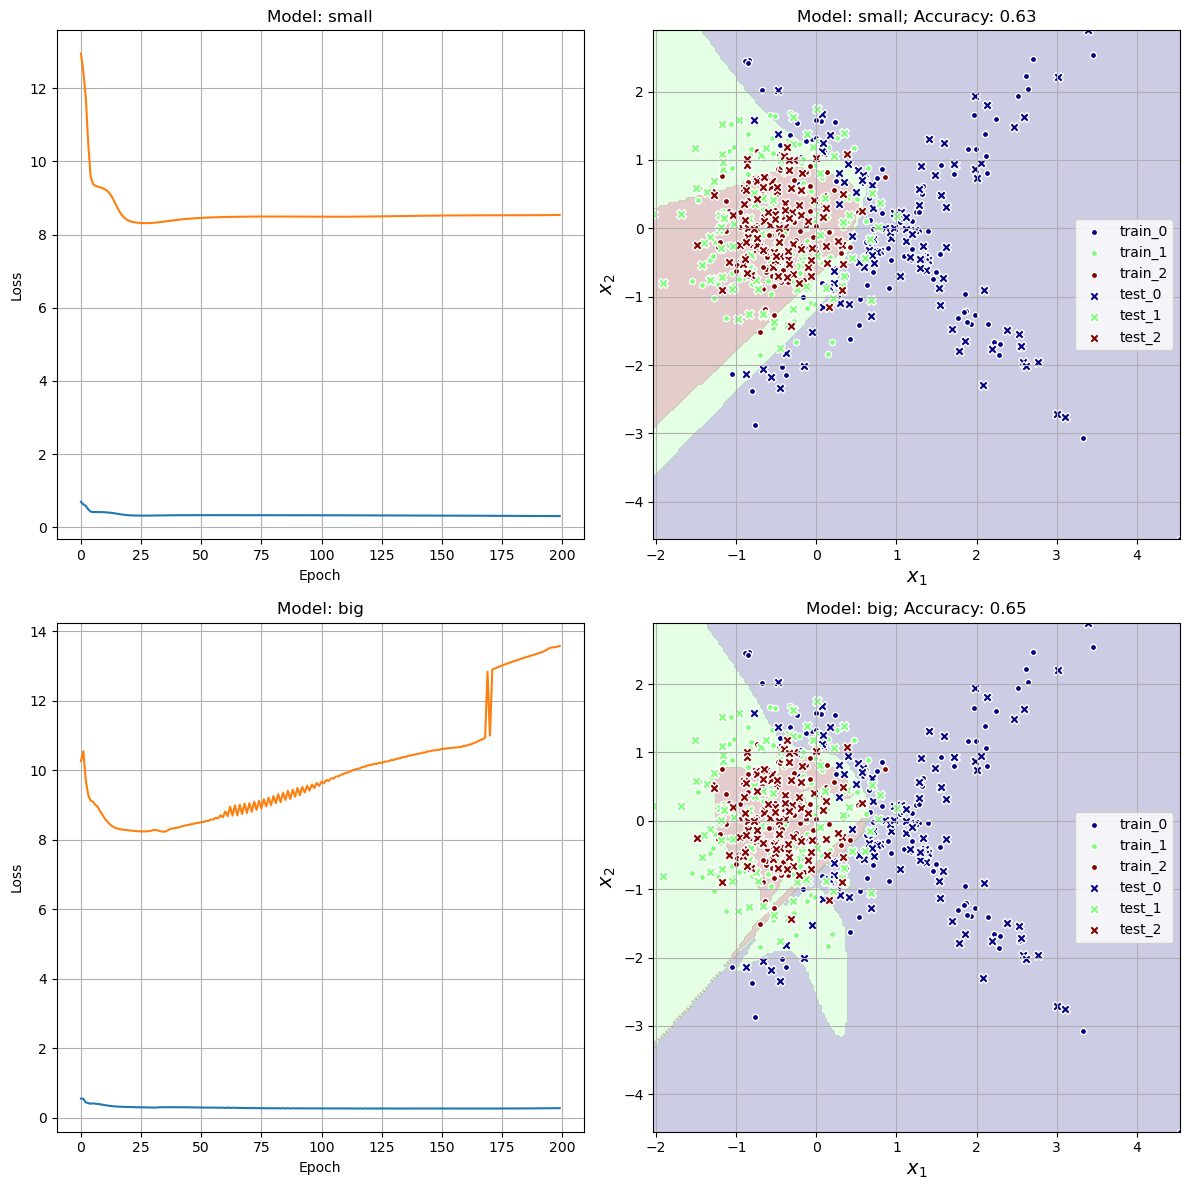

In [18]:
models_dict = {'small': Classifier(hidden_dim=4),
               'big': Classifier(hidden_dim=30)}


loss = nn.BCELoss()
LR = 3e-2
N_EPOCHS = 200

data_dict = {}
data_dict['train'] = {'X': X_train, 'y': y_train, 'm': 'o', 'msize':20}
data_dict['test'] = {'X': X_test, 'y': y_test, 'm': 'X', 'msize':50}

opts_dict = {'small': {'opt': torch.optim.Adam, 'params': {'lr': LR}},
             'big': {'opt': torch.optim.Adam, 'params': {'lr': LR}}}

opts_dict['default'] = opts_dict['small']

fit_and_compare(models_dict=models_dict,\
                data_dict=data_dict,
                loss = loss,
                opts_dict = opts_dict,
                train_loop = train_loop,
                n_epochs = N_EPOCHS,
                sq_size = 6,
                batch_size = 15)

Наблюдаем, что увеличение количества параметров в нашей модели привело к ухудшению качества её работы на тестовой выборке.

Это - проявление диллеммы смещения-дисперсии (bias-variance tradeoff).
В данном случае:
- *Смещение* — это погрешность оценки, возникающая в результате ошибочного предположения в алгоритме обучения. В результате большого смещения алгоритм может пропустить связь между признаками и выводом (недообучение).
- *Дисперсия* — это ошибка чувствительности к малым отклонениям в тренировочном наборе. При высокой дисперсии алгоритм начинает изучать случайный шум в тренировочном наборе, и способность об снижается (переобучение).

Диллемма смещения-дисперсии имеет место во многих задачах статистики и машинного обучения.

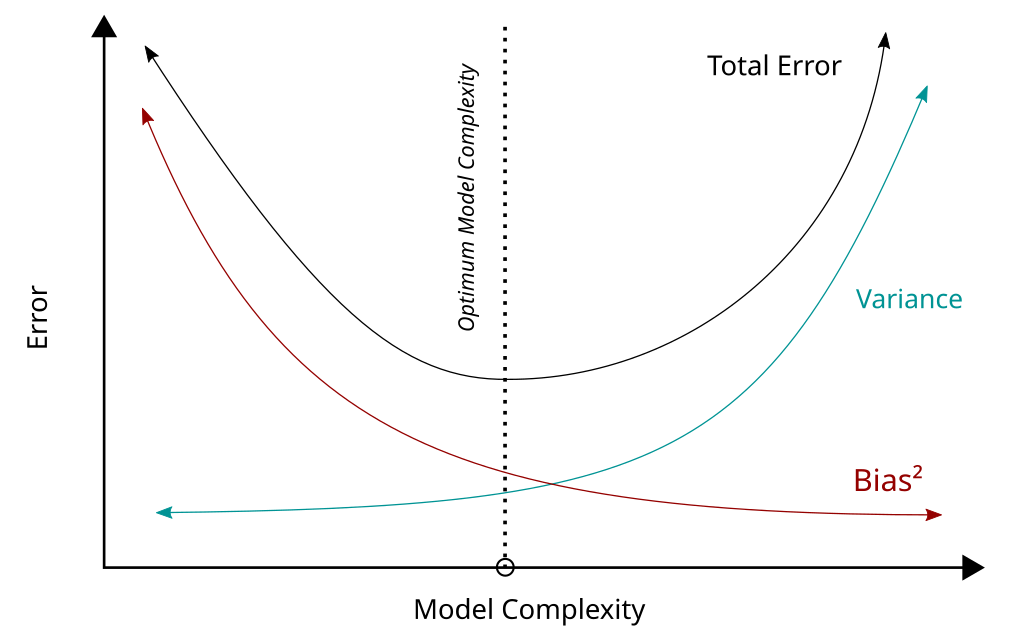


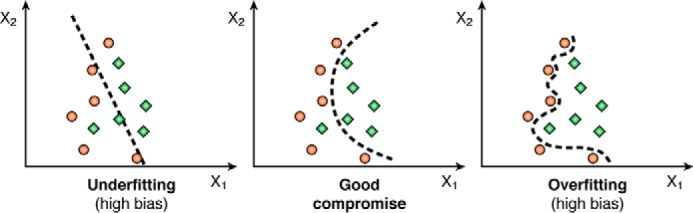

## 2.1. Борьба с переобучением. Регуляризация.

### 2.1.1. Lasso, Ridge и Elastic-net регуляризации

Одна из техник регуляризации - заставить модель "экономить", т.е. штрафовать её за величины весов.

Идея этого метода может быть вам знакома по задаче поиска условного минимума в математическом анализе (метод множителей Лагранжа) и другим математическим техникам. Смысл в том, чтобы в функции ошибки напрямую учесть какую-либо норму весов модели - тогда при минимизации функции ошибки эта норма тоже будет минимизирована.

Рассмотрим общее выражение для L1+L2 регуляризации:

$$ \texttt{loss}^R = \texttt{loss} + \alpha\sum_i{|w_i|} + \beta\sum_i{(w_j)^2} $$

В зависимости от параметров $\alpha$ и $\beta$ 
1. L1: $\alpha\neq0$, $\beta=0$ - lasso-регуляризация
2. L2: $\alpha = 0$, $\beta \neq 0$ - ridge-регуляризация
3. L1+L2: $\alpha \neq 0$, $\beta \neq 0$ - elastic net регуляризация

Качественно такая "поправка" приводит к картинке ниже:

0. Минимум $\texttt{loss}^R$ всегда лежит ближе к центру, чем реальный минимум $\texttt{loss}$. Для многослойной сети это хорошо, так как помогает избежать локальных минимумов.
1. Lasso(L1) регуляризация, в дополнение к (0), поощряет модель выделять наиболее полезные параметры, обнуляя остальные.
2. Ridge(L2) регуляризация позволяет справиться со скореллированными признаками (https://en.wikipedia.org/wiki/Multicollinearity)
3. Elastic-net совмещает оба подхода.

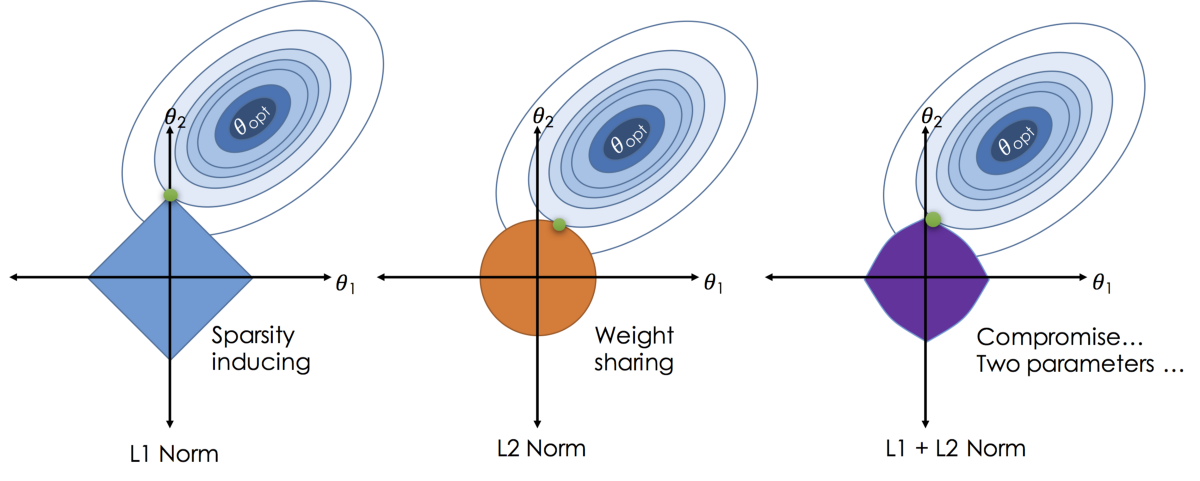

Итак, чтобы применить эти техники регуляризации, нам нужно модифицировать функцию ошибки... или нет?

Убедимся, что можно встроить L1+L2 регуляризацию в шаг обновления параметров модели:
$$ \texttt{loss}^R = \texttt{loss} + \alpha\sum_i{|w_i|} + \beta\sum_i{(w_j)^2} $$

$$ \frac{\partial}{\partial w_i}\texttt{loss}^R =  \frac{\partial}{\partial w_i} \texttt{loss} + \frac{\partial}{\partial w_i}\alpha\sum_i{|w_i|} + \frac{\partial}{\partial w_i}\beta\sum_i{(w_j)^2} $$

Первое и второе слагаемое в правой части мы умеем считать через backporpagation, а оставшиеся находятся довольно просто:
$$ \frac{\partial}{\partial w_i}\alpha\sum_i{|w_i|} = \alpha \frac{\partial}{\partial w_i} {|w_i|} = \alpha \texttt{sign}(w_i) $$
$$ \frac{\partial}{\partial w_i}\beta\sum_i{(w_i)}^2 = \beta \frac{\partial}{\partial w_i} {(w_i)}^2 = 2\beta w_i $$

Таким образом, для реализации этих техник нужно в коде оптимизатора добавить пару слагаемых. 

Вопрос на понимание:
- Посмотрите ещё раз на формулы выше и пробуйте угадать, lasso- или ridge-регуляризация чаще применяется на практике?

In [10]:
class AdamR(torch.optim.Optimizer):

    def __init__(self, params, lr=3e-4, mu=0.9, eps=1e-4, gma=0.9, alpha=0.0, beta=0.0, nesterov=False):

        defaults = {'lr':lr, 'mu':mu, 'eps': eps, 'gma': gma, 'nesterov': nesterov, 'alpha': alpha, 'beta': beta}
        super(AdamR, self).__init__(params, defaults)

    def step(self, closure=None):

        for group in self.param_groups:

            lr = group['lr']
            eps = group['eps']
            gma = group['gma']
            mu = group['mu']
            nesterov = group['nesterov']
            alpha = group['alpha']
            beta = group['beta']
            gma_ = 1 - gma

            for param in group['params']:

                if param.grad is None:
                    continue
                
                state = self.state[param]
                
                if 'gnorm' not in state:
                    state['gnorm'] = torch.zeros_like(param.data)

                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(param.data)

                grad = param.grad.data

                if alpha != 0:
                    grad = grad + alpha*torch.sign(param.data)
                if beta != 0:
                    grad = grad + 2*beta*param.data


                state['gnorm'] = state['gnorm']*gma + torch.pow(grad, 2)*gma_
                state['momentum'] = state['momentum']*mu - grad

                if nesterov:
                    d = mu*state['momentum'] - grad
                else:
                    d = state['momentum']

                param.data += lr*d/(torch.sqrt(state['gnorm'])+eps)


Optimizing model small


  1%|          | 6/500 [00:00<00:43, 11.35it/s]

100%|██████████| 500/500 [00:07<00:00, 69.90it/s] 


Optimizing model big


100%|██████████| 500/500 [00:05<00:00, 85.38it/s] 


All done!


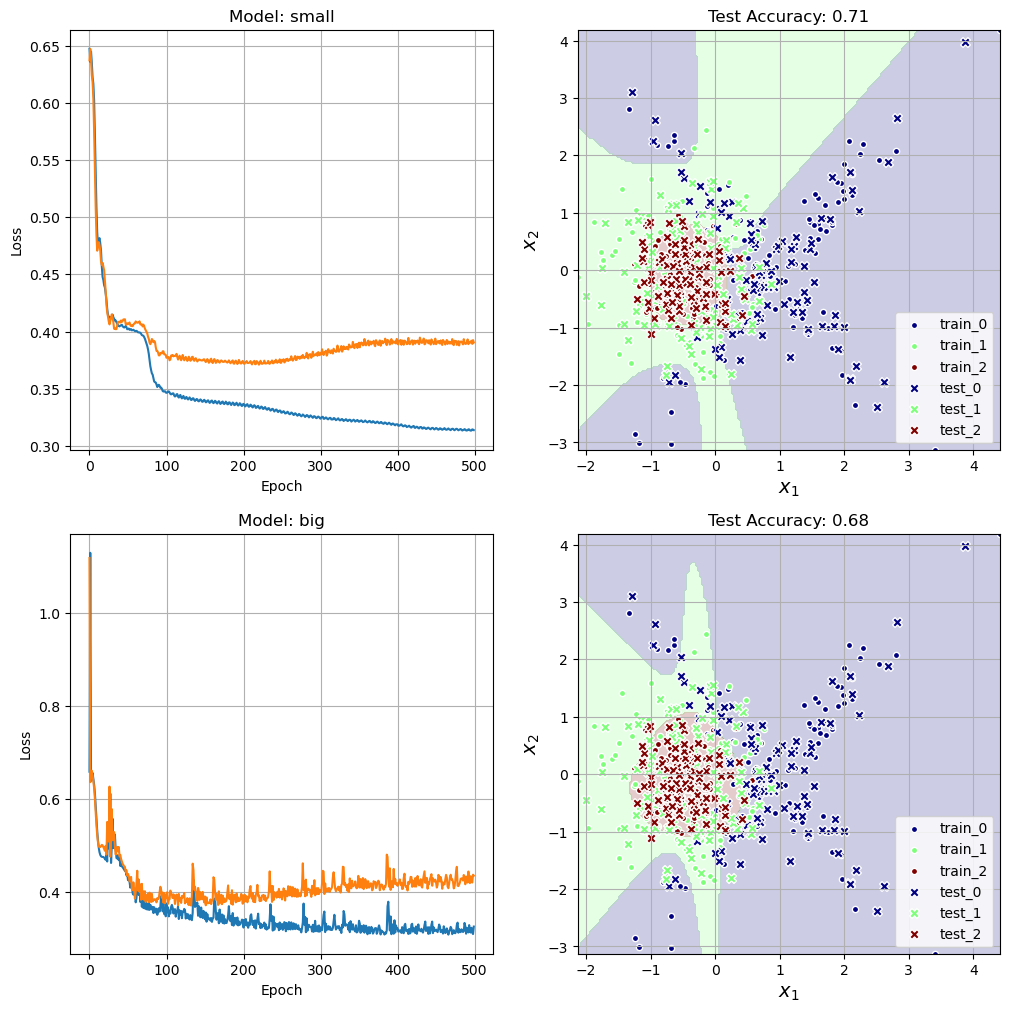

In [ ]:
models_dict = {'small': Classifier(hidden_dim=4),
               'big': Classifier(hidden_dim=30)}

data_ = {'train': (X_train, y_train),
         'test': (X_test, y_test)}

loss = nn.BCELoss()
LR = 3e-2
N_EPOCHS = 500
ALPHA = 3e-4

opts_dict = {'small': {'opt': AdamR, 'params': {'lr': LR, 'alpha': ALPHA}},
             'big': {'opt': AdamR, 'params': {'lr': LR, 'alpha': ALPHA}}}

opts_dict['default'] = opts_dict['small']

fit_and_compare(models_dict=models_dict,\
                data = data_,
                loss = loss,
                opts_dict = opts_dict,
                train_loop = train_loop,
                n_epochs = N_EPOCHS,
                sq_size=6)

                

### 2.1.2. Dropout

Вероятно, вы когда-нибудь слышали про людей с повреждениями мозга, которым (разумеется, после соответствующих медицинских вмешательств) удалось выжить и продолжить жить с минимальными изменениями личности, памяти и т.д. 

Классический для нейронаук пример - Финнеас Гейдж, живший в 19 веке и получивший травму ломом во время взрывотехнических работ на железной дороге. Сильно пострадала лобная доля мозга, а всего он потерял около 4% коры мозга.

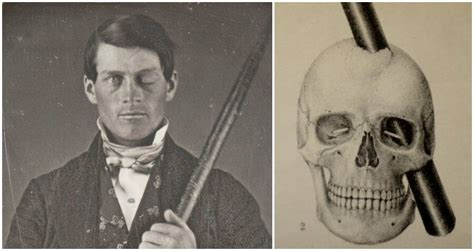

Это - яркое проявление нейропластичности мозга, т.е. его устойчивости относительно повреждения отдельных групп нейронов. 

Нейропластичность - одно из важнейших свойств человеческого мозга: было бы очень неудобно, если из-за гибели небольшой группы вследствие экзаменационной сессии вы бы забывали какой-нибудь раздел математики или, например, пароль от менеджера паролей.

Техника Dropout предложена в 2012-м году группой Джеффри Хинтона (https://arxiv.org/abs/1207.0580), вдохновлена нейропластичностью и позволяет реализовать её в нейросети.

Идея в том, чтобы случайно отключать некоторые связи ("нейроны") в сети, тогда остальные "нейроны" будут учиться решать задачу без участия этих связей:
 
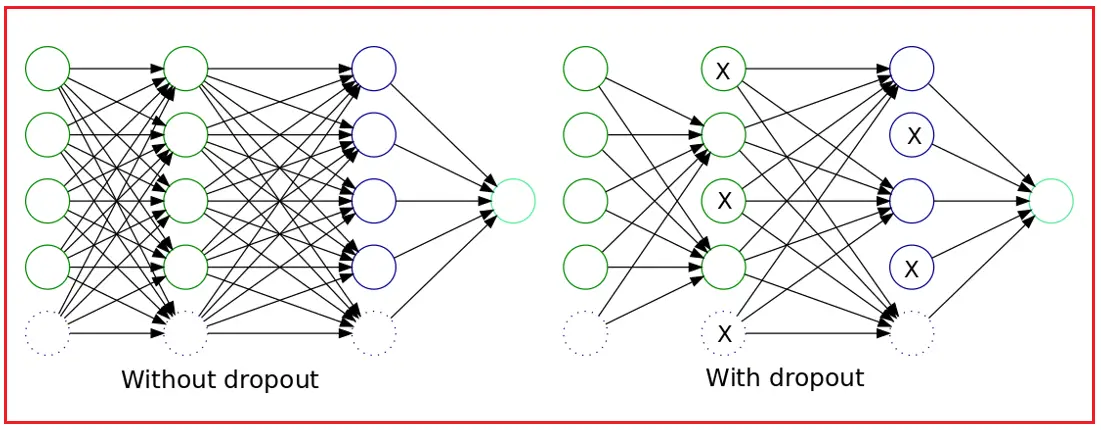

Реализуется Dropout с помощью специального слоя, который задаёт маску, обнуляющую некоторые связи, и обновляет её при каждом проходе. 

В примере выше между 2 и 3-м, а также между 3-м и выходным слоями стоят Dropout-слои. Разберём первый из них.

Пусть на выходе 2-го слоя будет вектор
$$ x_2 = [0.2, -0.3, 0.4, 0.2, 0.6, 0.1] $$
Согласно картинке, дропаутом отключаются 1й, 3й и 5й компоненты:
$$ x_2 \to x_2 =  [0.0, -0.3, 0.0, 0.6, 0.0] $$
Если рассмотреть действие 3-го слоя как матричное умножение:
$$ x_3 = \hat{w}_3 \cdot x_2 $$ 
Т.к. 1-я, 3-я и 5-я компоненты $x_2$ - нули, а матричное умножение выполняется по правилу "строка на столбец", веса матрицы $w_3$ из 1-го, 3-го и 5-го столбцов, фактически, не учасвуют в предсказании.

Вопросы на понимание:
1) Чему равен градиент на весах матрицы $w_3$  из 1-го, 3-го и 5-го столбцов?
2) Будет ли этот градиент рассчитываться при вызове `loss.backward`?

In [15]:
# Реализуйте Dropout
class Dropout(nn.Module):

    def __init__(self, p=0.5):
        '''
        Randomly zeroes some of the elements of the input tensor with probability p
        '''
        # YOUR CODE

        super(Dropout, self).__init__()
        self.p = p
        self.training = True
 

    def forward(self, X):

        # YOUR CODE
        if self.training == True:
            mask = torch.rand(X.shape) > self.p
            X = X * mask

        return X
   

Optimizing model small


100%|██████████| 500/500 [00:04<00:00, 101.03it/s]


Optimizing model big


100%|██████████| 500/500 [00:04<00:00, 106.81it/s]


Optimizing model dropout


100%|██████████| 500/500 [00:05<00:00, 89.38it/s] 


All done!


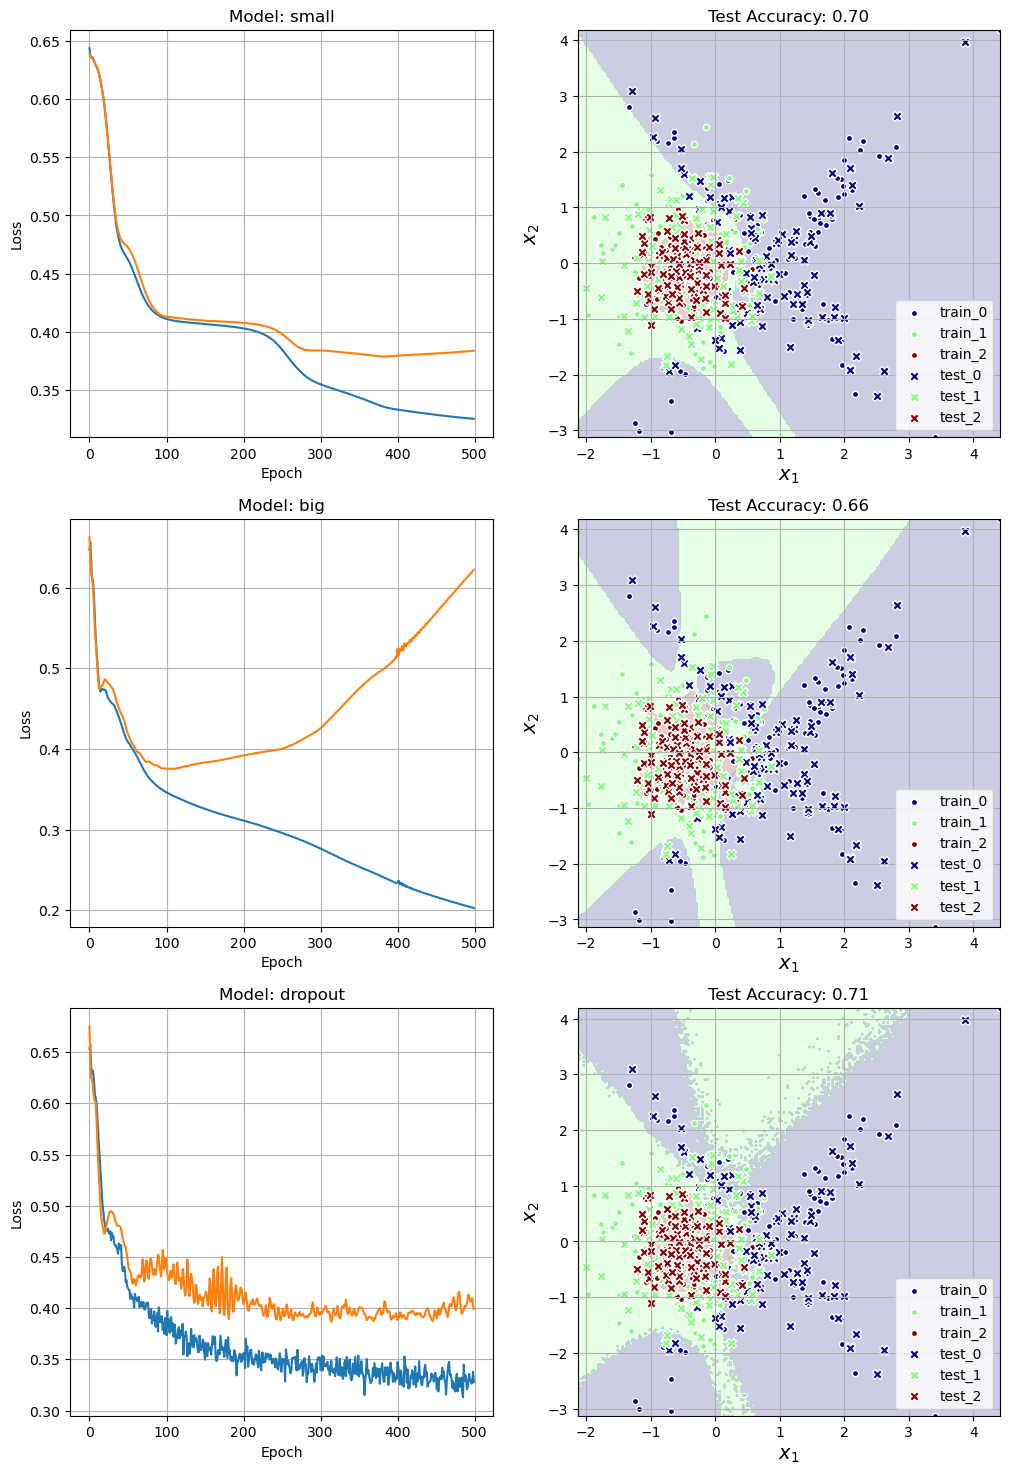

In [ ]:
n_features = 2
hidden_dim = 30
n_classes = 3

dropout_model = nn.Sequential(
    nn.Linear(n_features, hidden_dim),
    # Dropout(p=0.6),
    nn.Sigmoid(),
    nn.Linear(hidden_dim, hidden_dim),
    Dropout(p=0.3),
    nn.Sigmoid(),
    nn.Linear(hidden_dim, n_classes),
    nn.Softmax(dim=-1)
)

models_dict = {'small': Classifier(hidden_dim=4),
               'big': Classifier(hidden_dim=hidden_dim),
               'dropout': dropout_model}

data_ = {'train': (X_train, y_train),
         'test': (X_test, y_test)}

loss = nn.BCELoss()
LR = 3e-2
N_EPOCHS = 500

opts_dict = {'small': {'opt': torch.optim.Adam, 'params': {'lr': LR}},
             'big': {'opt': torch.optim.Adam, 'params': {'lr': LR}}}

opts_dict['default'] = opts_dict['small']

fit_and_compare(models_dict=models_dict,\
                data = data_,
                loss = loss,
                opts_dict = opts_dict,
                train_loop = train_loop,
                n_epochs = N_EPOCHS,
                sq_size=6)

                


### 2.1.3. Аугментация данных

Аугментация - тоже важная техника регуляризации.

Как можно догадаться по названию, суть этой техники в том, чтобы тем или иным образом модифицировать данные в процессе обучения, например:
- В случае неупорядоченных численных данных - добавлять случайный шум;
- В случае изображений - добвлять случайный шум, менять резкость, контрастность и цвета, поворачивать изображение и т.д.

В данной задаче такая техника не принесёт значительных результатов, поэтому будет рассмотрена позднее, когда будем работать с изображениями. Отметим лишь, что аугментация данных - довольно новое () и очень удобное изобретение, которое позволяет прийти к радикально лучшим результатам, в особенности - в задаче обработке изображений в случае малых тренировочных выборок.

## 2.2 Всё вместе

Теперь сравним качество обучения трёх моделей:
- Маленькая модель без регуляризации
- Большая модель без регуляризации
- Большая модель с регуляризацией   

In [ ]:
n_features = 2
hidden_dim = 30
n_classes = 3

dropout_model = nn.Sequential(
    nn.Linear(n_features, hidden_dim),
    # Dropout(p=0.6),
    nn.Sigmoid(),
    nn.Linear(hidden_dim, hidden_dim),
    Dropout(p=0.3),
    nn.Sigmoid(),
    nn.Linear(hidden_dim, n_classes),
    nn.Softmax(dim=-1)
)

models_dict = {'small': Classifier(hidden_dim=4),
               'big': Classifier(hidden_dim=hidden_dim),
               'dropout': dropout_model}

data_ = {'train': (X_train, y_train),
         'test': (X_test, y_test)}

loss = nn.BCELoss()
LR = 3e-2
N_EPOCHS = 500

opts_dict = {'small': {'opt': torch.optim.Adam, 'params': {'lr': LR}},
             'big': {'opt': torch.optim.Adam, 'params': {'lr': LR}}}

opts_dict['default'] = opts_dict['small']

fit_and_compare(models_dict=models_dict,\
                data = data_,
                loss = loss,
                opts_dict = opts_dict,
                n_epochs = N_EPOCHS,
                sq_size=6)


